# Student name and e-mail

name : 

e-mail : 

In [1]:
USE_GOOGLE_COLAB = False
MY_GOOGLE_DRIVE_PATH = 'TP_Modeling' # where files will be stored

In [2]:
if USE_GOOGLE_COLAB:
  from google.colab import drive
  from os.path import join 
  import os
  ROOT = "/content/drive/"     # default location for the drive

  PROJECT_PATH = join(ROOT, 'MyDrive', MY_GOOGLE_DRIVE_PATH)
  BASE_PATH = join(ROOT, 'MyDrive')
  
  drive.mount(ROOT, force_remount=False)           # we mount the google drive at /content/drive

  os.chdir(BASE_PATH)

  try:
    os.mkdir(PROJECT_PATH)
  except FileExistsError:
    pass
  os.chdir(PROJECT_PATH)

  ! git clone https://github.com/GFuhr/MF_FCM6.git
  
  os.chdir('./MF_FCM6/')
  ! git pull origin master
  os.chdir('./python')

  print('current folder')
  print(os.getcwd())

# python modules

In [3]:
%load_ext cython

In [4]:

from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation

import cython
import datetime
import numpy as np
import os
try:
    import yaml
    HAS_YAML=True
    display('Good News, YAML format accepted')
except ImportError:
    import json as js
    HAS_YAML=False
    display('only json accepted')

# if you have trouble seeing animations in the notebook, you can try to replace this line : 
%matplotlib inline
# with this one 
# %matplotlib notebook

'Good News, YAML format accepted'

function used to generate animations and compute computation time

# Additional functions

<font size=3>
    Functions defined here have been made to simplify representation of outputs. These functions are not part of the labs and can be used directly
</font>

In [5]:
from utils.timer import Timer
from utils.plotting import plot_results, plot_profile, figformat

In [6]:
from utils.file import save_outputs

def save_with_params(output, params):
    prefix = ''
    if params.get('C', None) is not None:
        prefix = 'diff_'
    if params.get('V', None) is not None:
        prefix += 'adv_'
    prefix += '{0:03d}_'.format(params['Nx'])
    save_outputs(output, prefix=prefix)

In [7]:
def load_from_string(params_str:str):
    """
    function used to load parameters from a string and load it into a dict used by simulations
    return : dict or ValueError if scheme is not correct
    """
    if not HAS_YAML:
        data = js.loads(params_str)
    else:
        data = yaml.safe_load (params_str)
    data['V'] = np.double(data['V'])
    try:
        data['Nx'] = int(data['Nx'])
    except TypeError:
        raise ValueError('Nx Value missing or not written as a number')
    try:
        data['Ny'] = int(data['Ny'])
    except TypeError:
        raise ValueError('Ny Value missing or not written as a number')
    except KeyError:
        print('Ny key not found')
    data['scheme'] = data['scheme'].lower().strip()
    if data['scheme'] not in ('eule', 'euli', 'rk2', 'rk4', 'cn'):
        raise ValueError('unknown time scheme')
    return data

In [8]:
# function extracting the max value and his position for each serie of a list of profiles
def extract_max(Frames):
    list_max = np.zeros(shape=(2, len(Frames)))
    idx = 0
    for frame in Frames:
        list_max[:,idx] = (frame.argmax(), frame.max())
        idx += 1
    return np.asarray(list_max)

# compute Fourier transform for a given field
def fourier_transform(field:(list, np.array), dx:float)->(np.array, np.array):
    if isinstance(field, list):
        ffield = np.array([np.fft.rfft(f[1:-1]) for f in field])
        field_dim = field[0].shape[0]
        field_dim_kx = ffield[0].shape[0]
    else:
        ffield = np.fft.rfft(field[1:-1])
        field_dim = field.shape[0]
        field_dim_kx = ffield.shape[0]

    kx = 2*np.pi/(dx*(field_dim-2))
    kfield = kx*np.arange(field_dim_kx)
    return ffield, kfield

# Definition of Finite difference functions used to resolve convection-diffusion equation

In [9]:
os.getcwd()
folder = os.path.split(os.getcwd())
if ('h2d' in folder) or ('advdiff' in folder):
    try:
        os.mkdir('../run')
    except FileExistsError:
        pass
    os.chdir('../run')
elif ('run' in folder):
    pass
elif ('python' in folder):
    try:
        os.mkdir('./run')
    except FileExistsError:
        pass
    os.chdir('./run')
    
display(HTML('<font size=4> data saved in the ./run subfolder </font>'))

In [10]:
%%cython
import numpy as np
import pyximport

pyximport.install(reload_support=True, setup_args = {'include_dirs': np.get_include()})

In [11]:
import importlib
os.chdir('../advdiff')
try: 
    importlib.reload(advdiff); import advdiff
except NameError:
    import advdiff
os.chdir('../run')

display(HTML('AdvDiff imported in current notebook'))

<frozen importlib._bootstrap>:241: RuntimeWarning: bicgstab.MatrixSolver size changed, may indicate binary incompatibility. Expected 1712 from C header, got 1720 from PyObject


## function used for initial condition
If/When you modify this function, don't forget to execute again the cell (press shift+enter for that)

In [12]:
def initfield_1D(x: np.array):
    """
    generate initial profile for advdiff simulations,
    :param x: meshgrid for X values
    :return: 1D field
    """
    u0 = np.zeros(x.shape)
    u0 = np.exp(-(x-.5*x.max())**2/100)

    # exemple for gate
#     u0[:] = 1
#     u0[0:u0.shape[0]//4] = 0
#     u0[3*u0.shape[0] // 4:] = 0
    return u0

In [13]:

# run the simulation corresponding to given parameters
def simulate(verbose=False, **kwargs):
    if kwargs.get('boundaries') is None : 
        kwargs['boundaries'] = 'per'
    if kwargs.get('derivative') is None : 
        kwargs['derivative'] = 'bwd'
    if kwargs.get('init') is None : 
        kwargs['init'] = initfield_1D
    
    return advdiff.simulate_1d(verbose, **kwargs)



## definition of simulation's parameters

In [14]:

# list of parameters used in both advdiff et H2D.
# Remark : the # starting line indicates a comment and is not necessary

# definition of parameter input to be used
"""
# time step
dt: .000001

# x step
dx:  .015

# y step (used only for H2D simulations)
dy: .01

# Points in X direction
Nx:  128

# Points in Y direction
Ny: 128

# modes in Y direction
Nm:  32

# wave number in Y direction
ky: .1

# end time
Tmax: .00001

# output time
Toutput: .000001

# diffusion coefficient
C:  .02

# advection coefficient
V:  -.2

# time scheme
# can be
# eule for euler explicit (default)
# euli for euler implicit
# RK2 for Runge-Kutta 2
# RK4 for Runge-Kutta 4
# CN for Cranck-Nicholson
scheme: eule
"""
;

''

# Section 0 : Introduction

Solve convection-diffusion equation : 
$$\Large \frac{\partial u(x,t)}{\partial t}+V\frac{\partial u(x,t)}{\partial x} = C\frac{\partial^2 u(x,t)}{\partial x^2}$$
$$\Large u(x, t=0) = u_0(x) $$
$$\Large u(0, t) = u(L_x, t) $$

<font size=4>
<p>First, we define parameters in a string which will then be used for the simulation. All the parameters are described in the upper cell.
This variable is converted to an usable dict through the function load_from_string.
    </p>
</font>

### Diffusion Only

$$\Large \frac{\partial u(x,t)}{\partial t} = C\frac{\partial^2 u(x,t)}{\partial x^2}$$
$$\Large u(0, t) = u(L_x, t) $$
$$\Large u(x, 0) = \exp\left( -x^2/\sigma^2\right) $$

<font size=4>
    If YAML format is not accepted, parameters should be written in the following format : each variable must have " around is name and each line terminated with a comma
</font>

In [15]:
params_ex_diff_str = """{
"C": 0.04,
"Nx": 256,
"Tmax": .000001,
"Toutput": .0000001, 
"V": 0,
"dt": 0.000000001,
"dx": 0.1,
"scheme": "eule"
}
"""
params_ex_diff = load_from_string(params_ex_diff_str)
display(params_ex_diff)

Ny key not found


{'C': 0.04,
 'Nx': 256,
 'Tmax': 1e-06,
 'Toutput': 1e-07,
 'V': 0.0,
 'dt': 1e-09,
 'dx': 0.1,
 'scheme': 'eule'}

<font size=4>
    If YAML format is accepted, parameters can be written following this format. If YAML is not recognized, you will have an error message.
</font>

In [16]:
params_ex_diff_str = """
C: 0.0
Nx: 512
Tmax: 500
Toutput: 1 
V: -0.2
dt: 0.12
dx: 0.1
scheme: rk4
"""
params_ex_diff = load_from_string(params_ex_diff_str)
display(params_ex_diff)

Ny key not found


{'C': 0.0,
 'Nx': 512,
 'Tmax': 500,
 'Toutput': 1,
 'V': -0.2,
 'dt': 0.12,
 'dx': 0.1,
 'scheme': 'rk4'}

<font size=4> 
    To run a new simulation you just need to use the function simulate with the parameters written previously as argument
</font>

In [17]:
%%time
tout, output_ex_diff, _ = simulate(**params_ex_diff, verbose=False)

total execution time in µs : 646048
number of snapshots : 500
used time for 1 time step : 155.04 µs
CPU times: user 32.7 s, sys: 0 ns, total: 32.7 s
Wall time: 1.65 s


<font size=4> 
    To see the result as an animation you can use the function plot_results with the returned value from the function simulate as argument
</font>

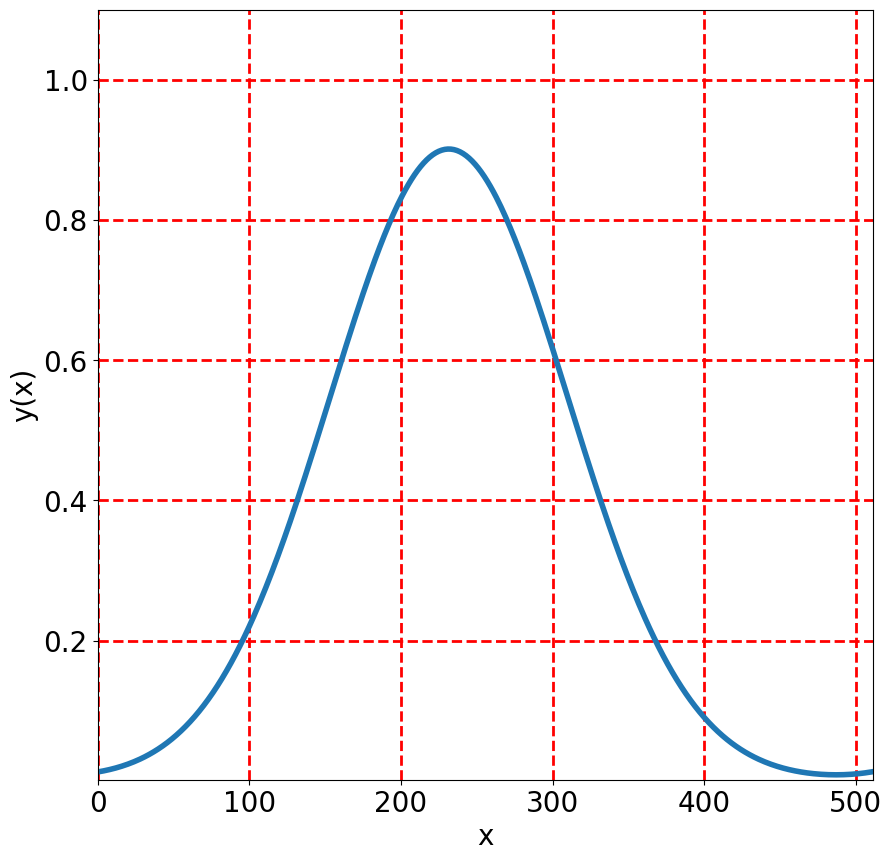

In [18]:

output = plot_results(output_ex_diff)
output

<font size=4>
    to compute the Fourier transform in space of the result
</font>

In [19]:
ffield, kx = fourier_transform(output_ex_diff , params_ex_diff['dx'])

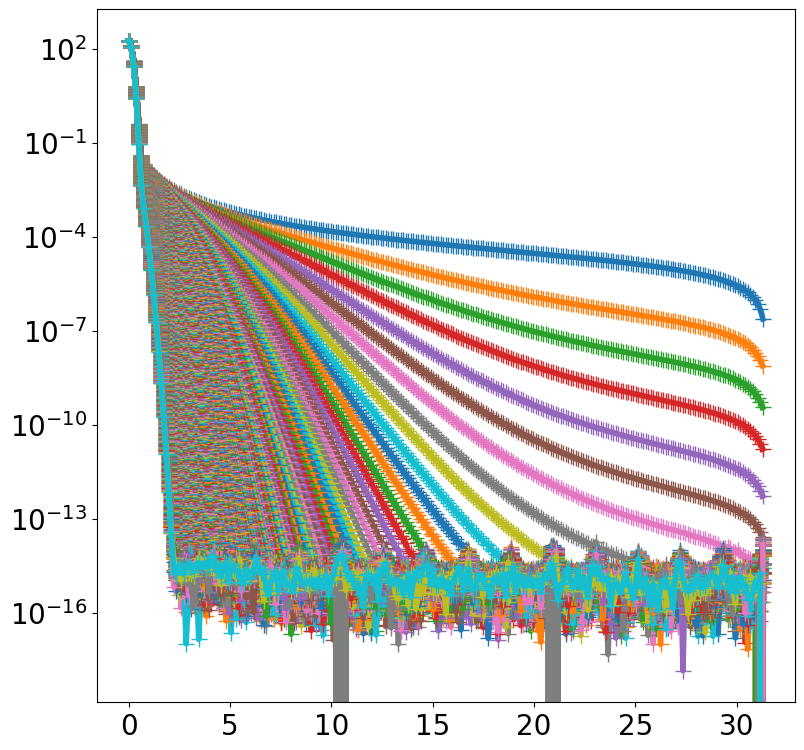

In [20]:
# this will plot the square modulus of each mode as function of the associated wavenumber
for f in ffield:
    plt.semilogy(kx[:-1], np.abs(f)[:-1], '+-')
    
plt.show()

In [21]:
print(len(ffield))

500


/tmp/ipykernel_2333/1495446015.py:3: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(kx,np.arange(len(ffield)),np.log(np.abs(ffield)))


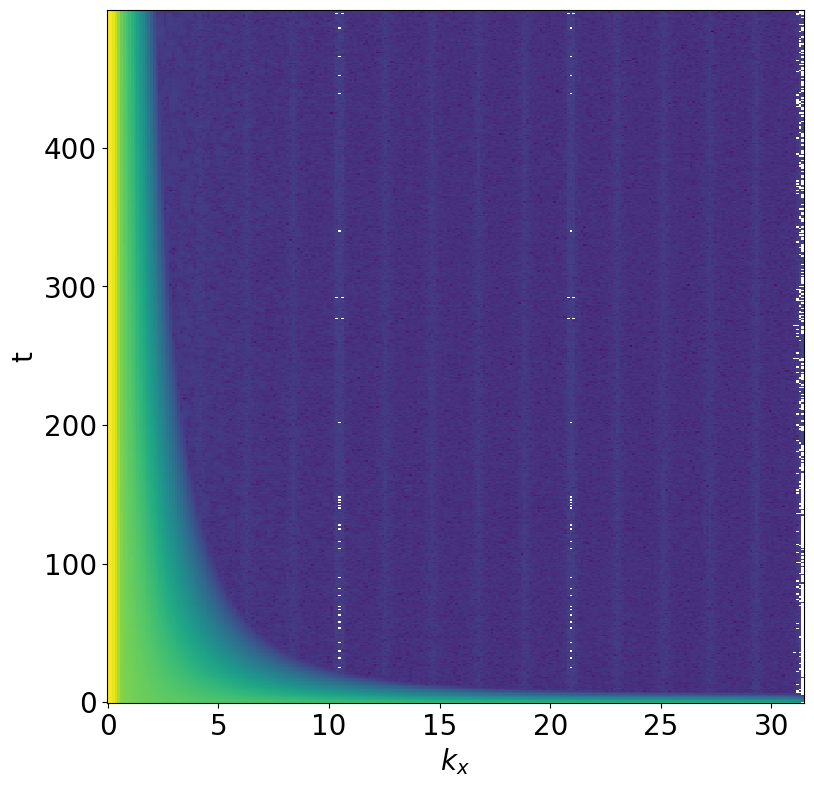

In [22]:
#plt.xscale('symlog')
#plt.yscale('symlog')
plt.pcolormesh(kx,np.arange(len(ffield)),np.log(np.abs(ffield)))
# this will plot the square modulus of each mode as function of the associated wavenumber
plt.xlabel("$k_x$")
plt.ylabel("t")
plt.show()

<font size=4>
    to plot last snapshot
</font>

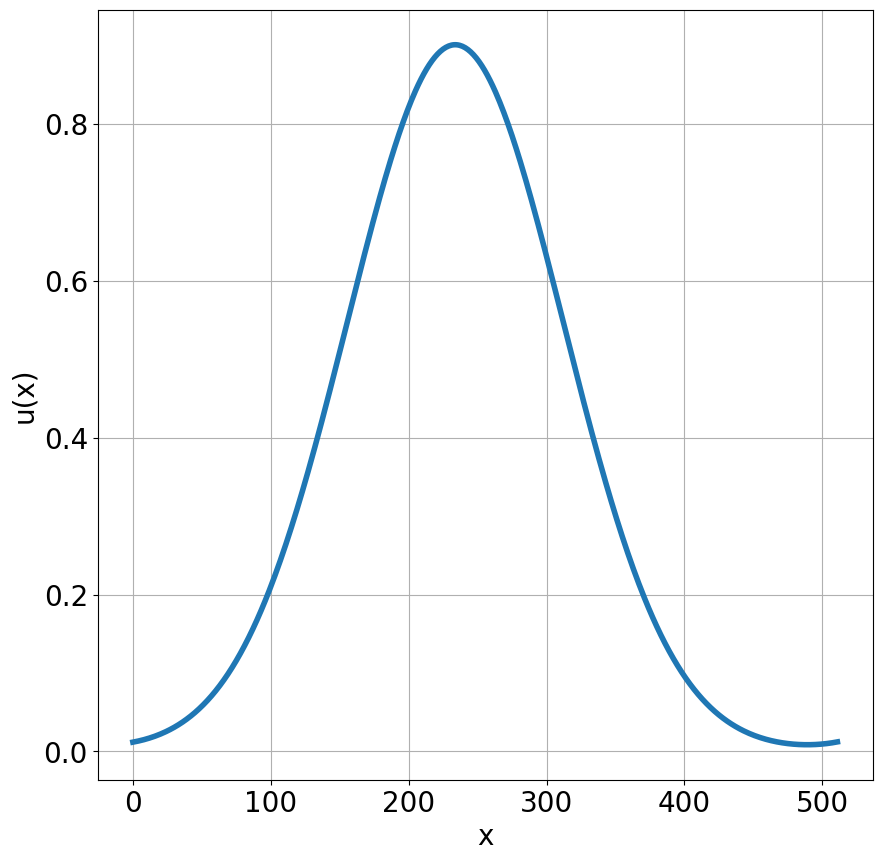

In [23]:
plot_profile(output_ex_diff, -1)
plt.show()

<font size=4>
    to plot evolution of max(u(x,t)) in time
</font>

''

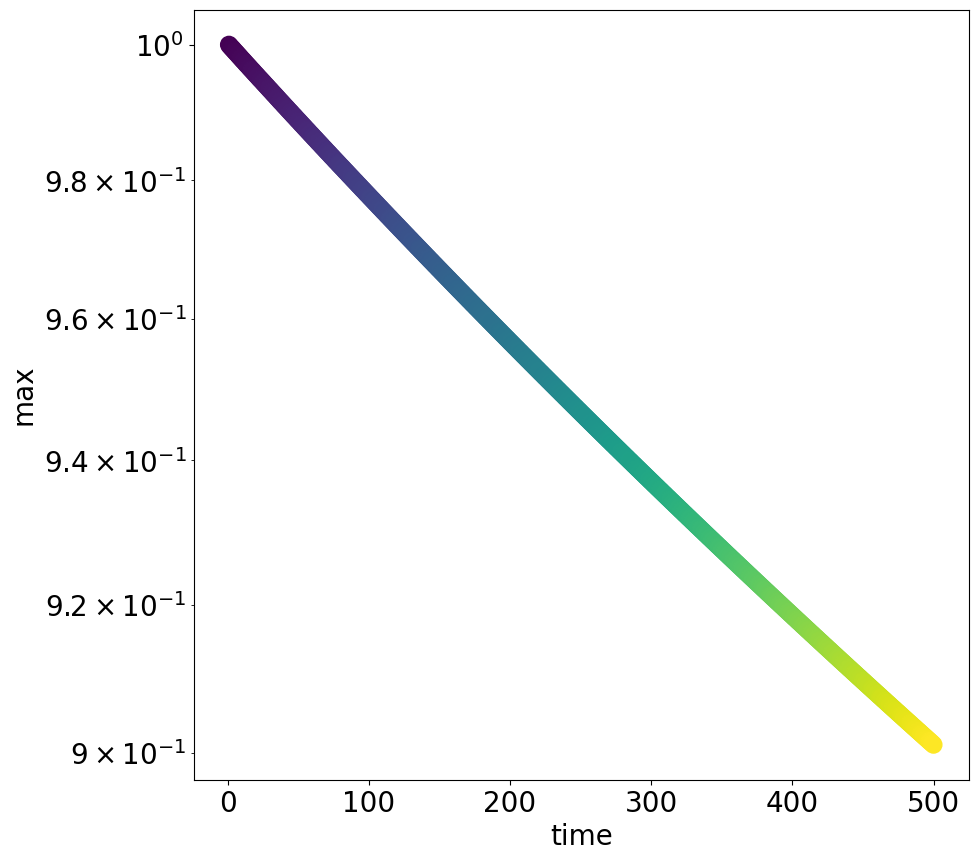

In [24]:
figformat().apply()
plt.figure(figsize=(10,10))
plt.grid(False)
ax = plt.gca()
x = extract_max(output_ex_diff)[0]
y = extract_max(output_ex_diff)[1]
t = 1+np.arange(*x.shape)
ax.scatter(t, y, c=t)
# set log scale in y
ax.set_yscale('log')
# set log scale in x
# ax.set_xscale('log')

plt.xlabel('time')
plt.ylabel('max')
;

To save results of a simulation : 

In [25]:
save_with_params(output_ex_diff, params_ex_diff)

data saved in file [diff_adv_512_0000_0002.txt]


### Section 1 : diffusion

In [26]:
# fill this parameters to resolve time evolution of 1D diffusion

params_for_diff = """
C: 
Nx: 
Tmax: 
Toutput: 
V: 0
dt: 
dx: 
scheme: eule
"""
params_diff = load_from_string(params_for_diff)
display(params_diff)

ValueError: Nx Value missing or not written as a number

## Stability analysis

Compute and plot outputs for the following conditions :

### $C\Delta t /\Delta x^2 < 1/2$

### $C\Delta t /\Delta x^2 = 1/2$

### $C\Delta t /\Delta x^2 > 1/2$

### $C\Delta t /\Delta x^2 = 1/2 - \epsilon$

### $C\Delta t /\Delta x^2 = 1/2 + \epsilon$

<font size=4> Comparing previous results, is CFL condition confirmed numerically?</font>

### compute growth rate of diffusion in the case where CFL < 1/2

You can use the function extract_max to obtain usefull infos concerning maximal value of the profile at each output time step

<font size=4>
    Analytic growth rate for diffusion is equal to  :
<font>
$$ u(x,0) = A \sin \left( k_x x\right) \Rightarrow \gamma = -C k_x^2$$
Are the numerical and analytical values comparable?

## Runge-Kutta 4 scheme

In [ ]:
params['scheme'] = 'RK4'
params['V'] = 0

<font size=4> 
    estimate stability limit using RK4 scheme
</font>

## Implicit Euler scheme

In [ ]:
params['scheme'] = 'euli'
params['V'] = 0

Plot results for CFL = .1, .5, 1

Is implicit scheme always stable?

# Part 2 :  Advection

In [ ]:
# fill this parameters to resolve time evolution of 1D diffusion

params_for_diff = """
C: 0
Nx: 
Tmax: 
Toutput: 
V: ??
dt: 
dx: 
scheme: eule
"""
params_diff = load_from_string(params_for_diff)
display(params_diff)

kind of derivatives :

definition of advection :

simulation with $u(x,t=0) = sin$, modify the function initfield_1D

In [ ]:
def initfield_1D(x: np.array):
    """
    generate initial profile for advdiff simulations,
    :param x: meshgrid for X values
    :return: 1D field
    """
    u0 = np.zeros(x.shape)
    u0 = np.exp(-(x-.5*x.max())**2/10)

    # exemple for gate
#     u0[:] = 1
#     u0[0:u0.shape[0]//4] = 0
#     u0[3*u0.shape[0] // 4:] = 0
    return u0

simulation with $u(x,t=0) = gate$, modify the function initfield_1D

In [ ]:
def initfield_1D(x: np.array):
    """
    generate initial profile for advdiff simulations,
    :param x: meshgrid for X values
    :return: 1D field
    """
    u0 = np.zeros(x.shape)
    u0 = np.exp(-(x-.5*x.max())**2/10)

    # exemple for gate
#     u0[:] = 1
#     u0[0:u0.shape[0]//4] = 0
#     u0[3*u0.shape[0] // 4:] = 0
    return u0

Comments : 

estimation of diffusion rate

$V\Delta t/ \Delta x <1$

$V\Delta t/ \Delta x == 1$

$V\Delta t/ \Delta x >1$

$V\Delta t/ \Delta x =1-\epsilon$

$V\Delta t/ \Delta x =1+\epsilon$

estimation of stability limit using RK4 scheme

# Part 3 :  Advection+Diffusion

Estimation of diffusion rate

Estimation of diffusion rate with centered differences for convection